# SETUP IMPORT 
***
### Imports:


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import sys
import os
from typing import Tuple, Dict, Any

# ML imports
import sklearn
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import log_loss, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
import keras

# Performance imports
import psutil
from functools import wraps

2025-08-02 17:03:55.254923: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Python version: 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 08:06:15) [Clang 14.0.6 ]
Pandas version: 2.3.1
NumPy version: 2.0.2
Scikit-learn version: 1.7.1
Matplotlib version: 3.10.0
Seaborn version: 0.13.2
TensorFlow version: 2.18.1
Keras version: 3.6.0


# SETUP DATA 
***


In [4]:
# %pip install yfinance pandas-datareader requests beautifulsoup4 lxml

# mappestruktur
Path("data/raw").mkdir(parents=True, exist_ok=True)
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(parents=True, exist_ok=True)
Path("notebooks").mkdir(parents=True, exist_ok=True)


In [5]:
import yfinance as yf
import pandas_datareader as pdr
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

# tidsramme for data
end_date = datetime(2025, 7, 31)
start_date = end_date - timedelta(days=365*8)  # 8 år tilbage

print(f" Data periode: {start_date.strftime('%Y-%m-%d')} til {end_date.strftime('%Y-%m-%d')}")

 Data periode: 2017-08-02 til 2025-07-31


In [6]:
def get_sp500_components():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    try:
        tables = pd.read_html(url)
        df = tables[0]
        return df['Symbol'].tolist()
    except Exception as e:
        print(f"Fejl ved hentning af S&P 500 komponenter: {e}")
        # hvis fejl bruges følgende liste
        return ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V']

sp500_symbols_raw = get_sp500_components()
print(f"Fandt {len(sp500_symbols_raw)} S&P 500 aktier (rå)")
print(f"Første 10: {sp500_symbols_raw[:10]}")

# Yahoo Finance ticker format -> erstat punktum med bindestreg
sp500_symbols = [symbol.replace('.', '-') for symbol in sp500_symbols_raw]
print(f"\nFormaterede S&P 500 symboler (første 10): {sp500_symbols[:10]}")


Fandt 503 S&P 500 aktier (rå)
Første 10: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']

Formaterede S&P 500 symboler (første 10): ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [7]:
def get_c25_components():
    url = 'https://en.wikipedia.org/wiki/OMX_Copenhagen_25'
    try:
        tables = pd.read_html(url)
        df = tables[0]
        return df['Ticker symbol'].tolist()
    except Exception as e:
        print(f"Fejl ved hentning af C25 komponenter: {e}")
        # hvis fejl bruges følgende liste
        return ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V']
    
c25_symbols_raw = get_c25_components()
print(f"Fandt {len(c25_symbols_raw)} C25 aktier (rå):")
print(f"{c25_symbols_raw}")

c25_symbols = [symbol.replace(' ', '-') + '.CO' if not symbol.endswith('.CO') else symbol.replace(' ', '-') 
               for symbol in c25_symbols_raw]

# NDA.CO -> NDA-DK.CO
c25_symbols = [symbol.replace('NDA.CO', 'NDA-DK.CO') for symbol in c25_symbols]

print(f"\nFormaterede C25 symboler:")
print(f"{c25_symbols}")

Fandt 25 C25 aktier (rå):
['MAERSK A', 'MAERSK B', 'AMBU B', 'BAVA', 'CARL B', 'COLO B', 'DANSKE', 'DEMANT', 'DSV', 'GMAB', 'GN', 'ISS', 'JYSK', 'NKT', 'NDA', 'NOVO B', 'NSIS B', 'PNDORA', 'ROCK B', 'RBREW', 'SYDB', 'TRYG', 'VWS', 'ZEAL', 'ORSTED']

Formaterede C25 symboler:
['MAERSK-A.CO', 'MAERSK-B.CO', 'AMBU-B.CO', 'BAVA.CO', 'CARL-B.CO', 'COLO-B.CO', 'DANSKE.CO', 'DEMANT.CO', 'DSV.CO', 'GMAB.CO', 'GN.CO', 'ISS.CO', 'JYSK.CO', 'NKT.CO', 'NDA-DK.CO', 'NOVO-B.CO', 'NSIS-B.CO', 'PNDORA.CO', 'ROCK-B.CO', 'RBREW.CO', 'SYDB.CO', 'TRYG.CO', 'VWS.CO', 'ZEAL.CO', 'ORSTED.CO']


In [8]:
def create_dataframes(symbols, start_date, end_date, max_stocks, interval="1d"):
    """
    Args:
        symbols: Liste af aktie symboler
        start_date: Start dato for data
        end_date: Slut dato for data  
        max_stocks: Max antal aktier at hente (for demo - brug alle med None)
        interval: Data interval (1d, 1h, etc.)
    
    Returns:
        dict: {symbol: dataframe} og samlet dataframe med alle close priser
    """
    
    # symboler fra wiki
    selected_symbols = symbols[:max_stocks] if max_stocks else symbols
    
    print(f"Arbejder med {len(selected_symbols)} aktier")
    print(f"For perioden: {start_date.strftime('%Y-%m-%d')} til {end_date.strftime('%Y-%m-%d')}")
    
    # hent data for alle aktier
    all_stock_data = {}
    successful_downloads = 0
    
    for i, symbol in enumerate(selected_symbols, 1):
        try:
            ticker = yf.Ticker(symbol)
            hist = ticker.history(start=start_date, end=end_date, interval=interval)
            
            if not hist.empty:
                all_stock_data[symbol] = hist
                successful_downloads += 1
                print(f" ***OBS*** {i:3d}/{len(selected_symbols):3d} {symbol}: {len(hist)} data points")
            else:
                print(f" ***OBS*** {i:3d}/{len(selected_symbols):3d} {symbol}: Ingen data")
                
        except Exception as e:
            print(f"{i:3d}/{len(selected_symbols):3d} {symbol}: Fejl - {e}")
    
    print(f"\nRESULTAT: {successful_downloads}/{len(selected_symbols)} aktier hentet")
    
    # dataframe med close priser
    close_prices = pd.DataFrame()
    
    for symbol, data in all_stock_data.items():
        close_prices[symbol] = data['Close']
    
    print(f"Samlet dataframe: {close_prices.shape[0]} dage x {close_prices.shape[1]} aktier")
    print(f"Dato range: {close_prices.index[0]} til {close_prices.index[-1]}")
    
    return all_stock_data, close_prices


In [9]:
print("KØRER TEST AF DATA HENTING:")
individual_sp_data, combined_sp_df = create_dataframes(
    symbols=sp500_symbols, 
    start_date=start_date, 
    end_date=end_date, 
    max_stocks=5  # TEST ALLE (ÆNDRE TIL 5 FOR AT TESTE MINDRE SUBSET)
)

KØRER TEST AF DATA HENTING:
Arbejder med 5 aktier
For perioden: 2017-08-02 til 2025-07-31
 ***OBS***   1/  5 MMM: 2009 data points
 ***OBS***   2/  5 AOS: 2009 data points
 ***OBS***   3/  5 ABT: 2009 data points
 ***OBS***   4/  5 ABBV: 2009 data points
 ***OBS***   5/  5 ACN: 2009 data points

RESULTAT: 5/5 aktier hentet
Samlet dataframe: 2009 dage x 5 aktier
Dato range: 2017-08-02 00:00:00-04:00 til 2025-07-30 00:00:00-04:00


In [10]:
# funktionen med danske aktier
print("\nKØRER TEST AF DANSKE AKTIER:")
individual_c25_data, combined_c25_df = create_dataframes(
    symbols=c25_symbols,  # Danske aktier
    start_date=start_date,
    end_date=end_date,
    max_stocks=25 # ( =None for alle aktier, 5 for test subset)
)



KØRER TEST AF DANSKE AKTIER:
Arbejder med 25 aktier
For perioden: 2017-08-02 til 2025-07-31
 ***OBS***   1/ 25 MAERSK-A.CO: 1998 data points
 ***OBS***   2/ 25 MAERSK-B.CO: 1998 data points
 ***OBS***   3/ 25 AMBU-B.CO: 1998 data points
 ***OBS***   4/ 25 BAVA.CO: 1998 data points
 ***OBS***   5/ 25 CARL-B.CO: 1998 data points
 ***OBS***   6/ 25 COLO-B.CO: 1998 data points
 ***OBS***   7/ 25 DANSKE.CO: 1998 data points
 ***OBS***   8/ 25 DEMANT.CO: 1998 data points
 ***OBS***   9/ 25 DSV.CO: 1998 data points
 ***OBS***  10/ 25 GMAB.CO: 1998 data points
 ***OBS***  11/ 25 GN.CO: 1998 data points
 ***OBS***  12/ 25 ISS.CO: 1998 data points
 ***OBS***  13/ 25 JYSK.CO: 1998 data points
 ***OBS***  14/ 25 NKT.CO: 1998 data points
 ***OBS***  15/ 25 NDA-DK.CO: 1998 data points
 ***OBS***  16/ 25 NOVO-B.CO: 1998 data points
 ***OBS***  17/ 25 NSIS-B.CO: 1998 data points
 ***OBS***  18/ 25 PNDORA.CO: 1998 data points
 ***OBS***  19/ 25 ROCK-B.CO: 1998 data points
 ***OBS***  20/ 25 RBREW.CO: 

In [11]:
individual_c25_data['BAVA.CO'] # data for eks. NOVO

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-08-02 00:00:00+02:00,323.150482,325.523651,317.217468,317.217468,226254,0.0,0.0
2017-08-03 00:00:00+02:00,318.008545,323.545990,317.613007,318.008545,166460,0.0,0.0
2017-08-04 00:00:00+02:00,318.008545,319.986206,314.844269,316.426392,155146,0.0,0.0
2017-08-07 00:00:00+02:00,316.426392,318.799591,314.844269,316.426392,162839,0.0,0.0
2017-08-08 00:00:00+02:00,316.426392,317.613007,313.262146,316.426392,126679,0.0,0.0
...,...,...,...,...,...,...,...
2025-07-24 00:00:00+02:00,193.000000,240.600006,193.000000,233.000000,2129158,0.0,0.0
2025-07-25 00:00:00+02:00,230.000000,237.399994,226.500000,233.000000,1404605,0.0,0.0
2025-07-28 00:00:00+02:00,238.000000,242.399994,236.000000,238.199997,3188319,0.0,0.0


In [12]:
combined_c25_df.head()  # første rækker af  combined dataframe


,MAERSK-A.CO,MAERSK-B.CO,AMBU-B.CO,BAVA.CO,CARL-B.CO,COLO-B.CO,DANSKE.CO,DEMANT.CO,DSV.CO,GMAB.CO,...,NOVO-B.CO,NSIS-B.CO,PNDORA.CO,ROCK-B.CO,RBREW.CO,SYDB.CO,TRYG.CO,VWS.CO,ZEAL.CO,ORSTED.CO
Date,,,,,,,,,,,,,,,,,,,,,
2017-08-02 00:00:00+02:00,6758.112305,7216.649902,79.503136,317.217468,564.029114,444.224548,188.082199,166.000000,412.115479,1398.0,...,113.708611,256.636505,610.048340,122.560143,268.685852,177.455734,79.866859,113.570702,124.5,273.452850
2017-08-03 00:00:00+02:00,6554.742676,7041.409668,79.483452,318.008545,566.861450,442.571747,188.156570,165.300003,415.489532,1399.0,...,114.264534,257.255096,604.186646,122.130135,270.996277,176.367874,79.755447,110.750229,124.0,272.284637
2017-08-04 00:00:00+02:00,6586.029785,7062.651855,80.487091,316.426392,572.121338,445.051025,189.643982,163.399994,427.828857,1389.0,...,113.836914,257.785400,630.146118,124.022285,272.793182,177.727692,80.033951,112.912590,123.5,274.531219
2017-08-07 00:00:00+02:00,6617.319336,7062.651855,81.451347,316.426392,576.572144,446.290833,188.751541,163.500000,428.889343,1408.0,...,112.468460,261.143555,630.146118,124.710335,271.338531,177.795685,79.866859,113.570702,121.0,274.081879
2017-08-08 00:00:00+02:00,6685.108398,7147.616211,81.471039,316.426392,572.526062,452.902435,188.230942,164.399994,429.564178,1395.0,...,111.998047,254.957336,543.893555,124.022285,272.793182,177.183762,80.145340,114.886909,118.5,277.946014


### OVERSIGT OVER IMPLEMENTEREDE DATAFRAMES (SO FAR)
***
* individual_sp_data     - data for specifik aktie i s&p500 (USD)
* combined_sp_df     - closing priser (1d-interval) for alle aktier i s&p500 (USD)
* individual_c25_data     - data for specifik aktie i omxc25 (OBS: DKK)
* combined_c25_df     - closing priser (1d-interval) for alle aktier i omxc25 (OBS: DKK)


### BASALE INDIKATORE - FEATURE ENGINEERING
***
- Trend: SMA, EMA, MACD
- Momentum: RSI

#### SMA
***

**Simple Moving Average (SMA) formel:**

$$SMA = \frac{A_1 + A_2 + ... + A_n}{n}$$

**Hvor:**
- $A_n$ = prisen på et aktiv i periode n
- $n$ = antallet af samlede perioder

SMA bruges til at identificere trends i aktiekurser, glatte kortsigtede udsving og generere tekniske signaler for køb/salg. I denne analyse kan SMA hjælpe med at spotte perioder med opadgående eller nedadgående momentum og sammenligne både korte og lange trends

In [13]:
def sma(data: pd.DataFrame, window: int) -> pd.Series:
    """
    Args:
        data: DataFrame med aktie data
        window: Vindue størrelse for SMA
    
    Returns:
        pd.Series: SMA værdier
    """
    return data['Close'].rolling(window=window).mean()

# SMA kolonner til BAVA data
individual_c25_data['BAVA.CO']['SMA_Kort'] = sma(individual_c25_data['BAVA.CO'], window=40)
individual_c25_data['BAVA.CO']['SMA_Lang'] = sma(individual_c25_data['BAVA.CO'], window=100)


individual_c25_data['BAVA.CO'][['Close', 'SMA_Kort', 'SMA_Lang']]

,Close,SMA_Kort,SMA_Lang
Date,,,
2017-08-02 00:00:00+02:00,317.217468,NaN,NaN
2017-08-03 00:00:00+02:00,318.008545,NaN,NaN
2017-08-04 00:00:00+02:00,316.426392,NaN,NaN
2017-08-07 00:00:00+02:00,316.426392,NaN,NaN
2017-08-08 00:00:00+02:00,316.426392,NaN,NaN
...,...,...,...
2025-07-24 00:00:00+02:00,233.000000,178.66000,166.9695
2025-07-25 00:00:00+02:00,233.000000,180.21000,167.5775
2025-07-28 00:00:00+02:00,238.199997,181.84125,168.2480


#### EMA
***

**Exponemtial Moving Average (EMA) formel:**
$$
EMA_t = \alpha \cdot P_t + (1 - \alpha) \cdot EMA_{t-1}
$$

**Hvor:**
- $EMA_t$ = EMA for periode $t$
- $P_t$ = pris i periode $t$
- $\alpha = \frac{2}{n+1}$ (smoothing factor, $n$ = antal perioder)
- $EMA_{t-1}$ = EMA for forrige periode

EMA-værdierne bruges til at identificere trends og momentum i aktiekursen. De reagerer hurtigere på prisændringer end SMA og kan hjælpe med at spotte vendinger, støtte modstandsniveauer og generere tekniske køb/salg-signaler. I denne analyse giver EMA et mere dynamisk billede af kursudviklingen.

In [14]:
def ema(data: pd.DataFrame, window: int) -> pd.Series:
    """
    Args:
        data: DataFrame med aktie data
        window: Vindue størrelse for EMA
    
    Returns:
        pd.Series: EMA værdier
    """
    return data['Close'].ewm(span=window, adjust=False).mean()

individual_c25_data['BAVA.CO']['EMA_Kort'] = ema(individual_c25_data['BAVA.CO'], window=12)
individual_c25_data['BAVA.CO']['EMA_Lang'] = ema(individual_c25_data['BAVA.CO'], window=26)

individual_c25_data['BAVA.CO'][['Close', 'EMA_Kort', 'EMA_Lang']]

,Close,EMA_Kort,EMA_Lang
Date,,,
2017-08-02 00:00:00+02:00,317.217468,317.217468,317.217468
2017-08-03 00:00:00+02:00,318.008545,317.339172,317.276067
2017-08-04 00:00:00+02:00,316.426392,317.198745,317.213128
2017-08-07 00:00:00+02:00,316.426392,317.079921,317.154851
2017-08-08 00:00:00+02:00,316.426392,316.979378,317.100891
...,...,...,...
2025-07-24 00:00:00+02:00,233.000000,190.320890,182.564221
2025-07-25 00:00:00+02:00,233.000000,196.886907,186.300205
2025-07-28 00:00:00+02:00,238.199997,203.242767,190.144634


#### MACD
***
**MACD formel:**

$$
MACD = EMA_{kort} - EMA_{lang}
$$

- $EMA_{kort}$ = Exponential Moving Average med kort vindue (typisk 12 perioder)
- $EMA_{lang}$ = Exponential Moving Average med langt vindue (typisk 26 perioder)

MACD bruges til at identificere trends og momentum i aktiekurser. Når MACD er positiv, indikerer det opadgående momentum; når den er negativ, indikerer det nedadgående momentum. Kryds mellem MACD og dens signal-linje kan give køb/salgssignaler, og divergenser mellem MACD og pris kan advare om trendvendinger.

In [15]:
def macd(data: pd.DataFrame) -> pd.DataFrame:
    """
    Args:
        data: DataFrame med aktie data
    
    Returns:
        pd.DataFrame: DataFrame med MACD og signal linje
    """
    ema_12 = ema(data, window=12)
    ema_26 = ema(data, window=26)
    
    macd = ema_12 - ema_26
    signal_line = macd.ewm(span=9, adjust=False).mean()
    
    return pd.DataFrame({'MACD': macd, 'Signal_Line': signal_line})

individual_c25_data['BAVA.CO']['MACD'] = macd(individual_c25_data['BAVA.CO'])['MACD']
individual_c25_data['BAVA.CO']['Signal_Line'] = macd(individual_c25_data['BAVA.CO'])['Signal_Line']

individual_c25_data['BAVA.CO'][['Close', 'MACD', 'Signal_Line']].tail(10)  # Vis de sidste 10 rækker

,Close,MACD,Signal_Line
Date,,,
2025-07-17 00:00:00+02:00,182.449997,2.563813,1.563392
2025-07-18 00:00:00+02:00,184.600006,2.898403,1.830394
2025-07-21 00:00:00+02:00,184.649994,3.131503,2.090616
2025-07-22 00:00:00+02:00,185.449997,3.342263,2.340946
2025-07-23 00:00:00+02:00,192.500000,4.031693,2.679095
2025-07-24 00:00:00+02:00,233.000000,7.756669,3.694610
2025-07-25 00:00:00+02:00,233.000000,10.586702,5.073028
2025-07-28 00:00:00+02:00,238.199997,13.098133,6.678049
2025-07-29 00:00:00+02:00,237.000000,14.820786,8.306597


#### RSI
***
**Relative Strength Index (RSI) formel:**

$$
RSI = 100 - \left( \frac{100}{1 + RS} \right)
$$

hvor

$$
RS = \frac{\text{Gennemsnitlig gevinst over } n \text{ perioder}}{\text{Gennemsnitligt tab over } n \text{ perioder}}
$$

RSI er et momentum-indikator, der måler hastigheden og ændringen af prisbevægelser. RSI-værdier ligger typisk mellem 0 og 100. En RSI over 70 indikerer, at aktien kan være overkøbt, mens en RSI under 30 kan signalere, at aktien er oversolgt. RSI bruges til at identificere potentielle køb/salgssignaler og trendvendinger.

In [16]:
def rsi(data: pd.DataFrame, window: int = 14) -> pd.Series:
    """ 
    Args:
        data: DataFrame med aktie data
        window: Vindue størrelse for RSI
    
    Returns:
        pd.Series: RSI værdier
    """
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

individual_c25_data['BAVA.CO']['RSI'] = rsi(individual_c25_data['BAVA.CO'])
individual_c25_data['BAVA.CO'][['Close', 'RSI']].tail(10) 

,Close,RSI
Date,,
2025-07-17 00:00:00+02:00,182.449997,71.641833
2025-07-18 00:00:00+02:00,184.600006,74.568334
2025-07-21 00:00:00+02:00,184.649994,76.650581
2025-07-22 00:00:00+02:00,185.449997,76.461068
2025-07-23 00:00:00+02:00,192.500000,80.614995
2025-07-24 00:00:00+02:00,233.000000,90.248840
2025-07-25 00:00:00+02:00,233.000000,94.774015
2025-07-28 00:00:00+02:00,238.199997,94.959132
2025-07-29 00:00:00+02:00,237.000000,93.117984


In [17]:
# Kolonner med indikatorer og closepris
indicators_df = individual_c25_data['BAVA.CO'][['Close', 'SMA_Kort', 'SMA_Lang', 'EMA_Kort', 'EMA_Lang', 'MACD', 'Signal_Line', 'RSI']].copy()

indicators_df.tail(10)

,Close,SMA_Kort,SMA_Lang,EMA_Kort,EMA_Lang,MACD,Signal_Line,RSI
Date,,,,,,,,
2025-07-17 00:00:00+02:00,182.449997,175.44500,165.8405,178.025000,175.461187,2.563813,1.563392,71.641833
2025-07-18 00:00:00+02:00,184.600006,175.82125,165.9570,179.036539,176.138136,2.898403,1.830394,74.568334
2025-07-21 00:00:00+02:00,184.649994,176.15125,166.0660,179.900148,176.768644,3.131503,2.090616,76.650581
2025-07-22 00:00:00+02:00,185.449997,176.45875,166.1785,180.753971,177.411707,3.342263,2.340946,76.461068
2025-07-23 00:00:00+02:00,192.500000,177.03500,166.3780,182.561052,178.529359,4.031693,2.679095,80.614995
2025-07-24 00:00:00+02:00,233.000000,178.66000,166.9695,190.320890,182.564221,7.756669,3.694610,90.248840
2025-07-25 00:00:00+02:00,233.000000,180.21000,167.5775,196.886907,186.300205,10.586702,5.073028,94.774015
2025-07-28 00:00:00+02:00,238.199997,181.84125,168.2480,203.242767,190.144634,13.098133,6.678049,94.959132
2025-07-29 00:00:00+02:00,237.000000,183.44125,168.9365,208.436188,193.615402,14.820786,8.306597,93.117984


### INDIKATOR VISUALISERING
***

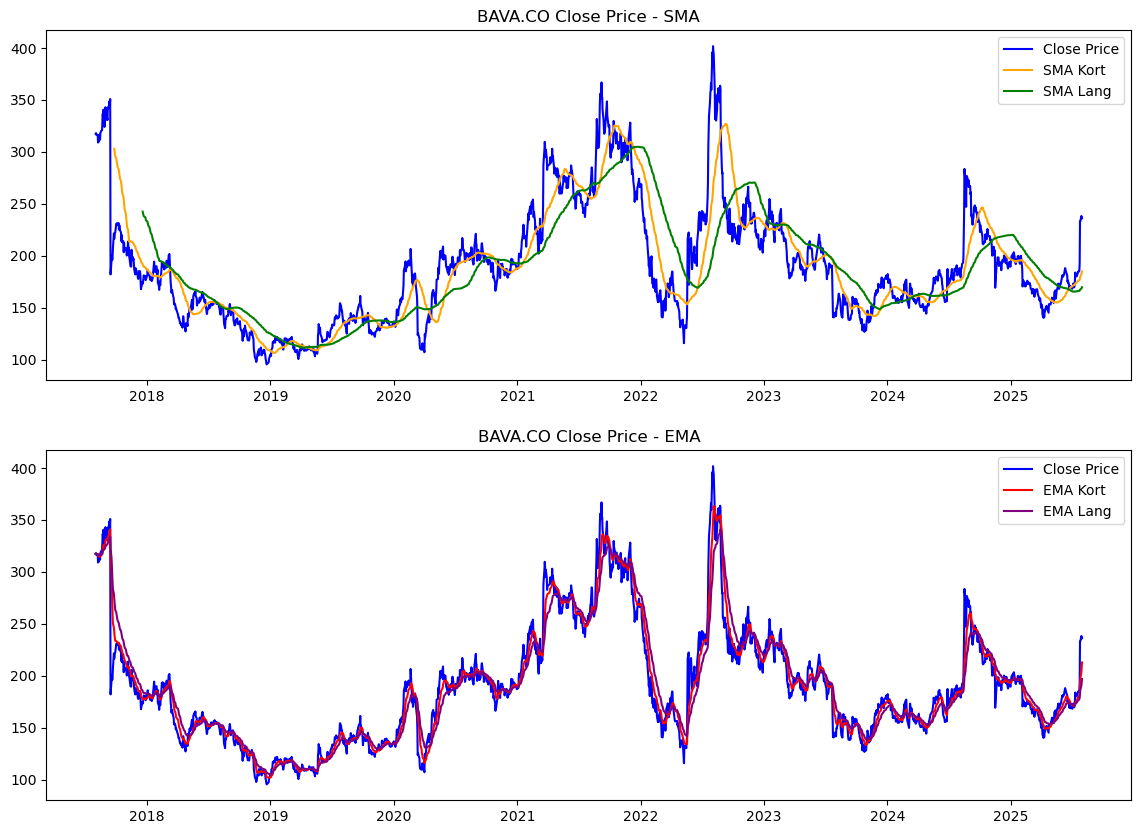

In [18]:
# Plot indikatorer - SMA og EMA
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(indicators_df['Close'], label='Close Price', color='blue')
plt.plot(indicators_df['SMA_Kort'], label='SMA Kort', color='orange')
plt.plot(indicators_df['SMA_Lang'], label='SMA Lang', color='green')
plt.title('BAVA.CO Close Price - SMA')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(indicators_df['Close'], label='Close Price', color='blue')
plt.plot(indicators_df['EMA_Kort'], label='EMA Kort', color='red')
plt.plot(indicators_df['EMA_Lang'], label='EMA Lang', color='purple')
plt.title('BAVA.CO Close Price - EMA')
plt.legend()


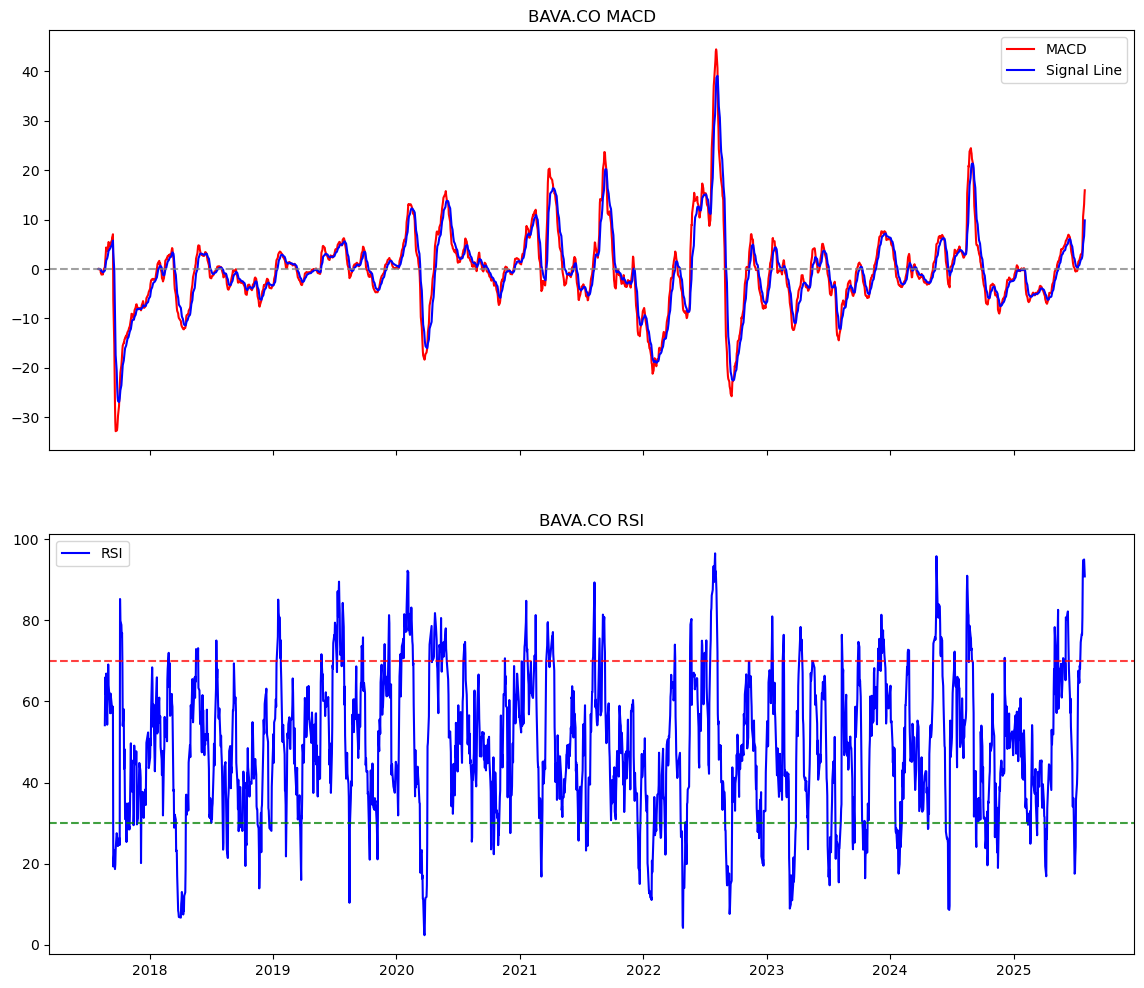

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

axes[0].plot(indicators_df.index, indicators_df['MACD'], label='MACD', color='red')
axes[0].plot(indicators_df.index, indicators_df['Signal_Line'], label='Signal Line', color='blue')
axes[0].axhline(0, linestyle='--', alpha=0.75, color='gray')
axes[0].set_title('BAVA.CO MACD')
axes[0].legend()

axes[1].plot(indicators_df.index, indicators_df['RSI'], label='RSI', color='blue')
axes[1].axhline(70, linestyle='--', color='red', alpha=0.75)
axes[1].axhline(30, linestyle='--', color='green', alpha=0.75)
axes[1].set_title('BAVA.CO RSI')
axes[1].legend()

### AUTOMATISERING AF INDIKATOR-UDREGNINGER (FOR FLERE TICKERS)
***

In [20]:
def indicators_ud(data: pd.DataFrame, 
                         sma_kort: int = 40, 
                         sma_lang: int = 100, 
                         ema_kort: int = 12, 
                         ema_lang: int = 26, 
                         rsi_window: int = 14) -> pd.DataFrame: 
    
    """
    Args:
    data: DataFrame med aktie data (skal indeholde 'Close' kolonne)
    sma_kort: Vindue for kort SMA (default: 40)
    sma_lang: Vindue for lang SMA (default: 100)
    ema_kort: Vindue for kort EMA (default: 12)
    ema_lang: Vindue for lang EMA (default: 26)
    rsi_window: Vindue for RSI (default: 14)

    Returns:
        pd.DataFrame: Nyt DataFrame med alle beregnede indikatorer
    """

    # Lav en kopi af dataframe for at undgå at ændre originalen
    result = data.copy()

    # Beregn SMA indikatorer
    result['SMA_Kort'] = sma(result, window=sma_kort)
    result['SMA_Lang'] = sma(result, window=sma_lang)

    # Beregn EMA indikatorer
    result['EMA_Kort'] = ema(result, window=ema_kort)
    result['EMA_Lang'] = ema(result, window=ema_lang)

    # Beregn MACD
    macd_values = macd(result)
    result['MACD'] = macd_values['MACD']
    result['Signal_Line'] = macd_values['Signal_Line']

    # Beregn RSI
    result['RSI'] = rsi(result, window=rsi_window)

    return result


In [21]:
def process_multiple_stocks(data: Dict[str, pd.DataFrame], 
                            symbols: list = None, 
                            save_to_csv: bool = True, 
                            save_path: str = "data/processed") -> Dict[str, pd.DataFrame]:
    """
    Args:
    data: Dictionary med aktie dataframes {symbol: dataframe}
    symbols: Liste over aktie symboler (hvis None, bruges alle i data)
    save_to_csv: Om resultater skal gemmes som CSV (default: True)
    save_path: Sti hvor CSV filer gemmes (default: 'data/processed')

    Returns:
        Dict: {symbol: dataframe med indikatorer}
    """

    all_indicators = {}
    processed = 0
    total = len(symbols)

    for symbol in symbols:
        try:
            if symbol in data:
                print(f"[{processed+1}/{total}] Beregner indikatorer for {symbol}...")
                all_indicators[symbol] = indicators_ud(data[symbol])
                
                # Gem CSV hvis ønsket
                if save_to_csv:
                    save_file = os.path.join(save_path, f"{symbol.replace('.', '_')}_indicators.csv")
                    all_indicators[symbol].to_csv(save_file)
                    print(f"Gemt som {save_file}")
                
                processed += 1
            else:
                print(f"***OBS***: Symbol {symbol} ikke fundet i data")
        except Exception as e:
            print(f"***OBS***: Fejl ved behandling af {symbol}: {str(e)}")

    print(f"\nBehandlet {processed} ud af {total} aktier")
    return all_indicators


def plot_stock_indicators(symbol: str, indicators_df: pd.DataFrame):
    """
    Plot indikatorer for en given aktie.
    
    Args:
        symbol: Aktie symbol
        indicators_df: DataFrame med indikatorer
    """
    plt.figure(figsize=(14, 10))
    
    # SMA & EMA plot
    plt.subplot(2, 1, 1)
    plt.plot(indicators_df['Close'], label='Close Price', color='blue')
    plt.plot(indicators_df['SMA_Kort'], label='SMA Kort', color='orange')
    plt.plot(indicators_df['SMA_Lang'], label='SMA Lang', color='green')
    plt.title(f'{symbol} Close Price - SMA')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(indicators_df['Close'], label='Close Price', color='blue')
    plt.plot(indicators_df['EMA_Kort'], label='EMA Kort', color='red')
    plt.plot(indicators_df['EMA_Lang'], label='EMA Lang', color='purple')
    plt.title(f'{symbol} Close Price - EMA')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # MACD & RSI plot
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(indicators_df['MACD'], label='MACD', color='red')
    plt.plot(indicators_df['Signal_Line'], label='Signal Line', color='blue')
    plt.axhline(0, linestyle='--', alpha=0.75, color='gray')
    plt.title(f'{symbol} MACD')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(indicators_df['RSI'], label='RSI', color='blue')
    plt.axhline(70, linestyle='--', color='red', alpha=0.75)
    plt.axhline(30, linestyle='--', color='green', alpha=0.75)
    plt.title(f'{symbol} RSI')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### EKSEMPEL PÅ BRUG AF AUTOMATISERINGEN
***

[1/5] Beregner indikatorer for BAVA.CO...
Gemt som data/processed/BAVA_CO_indicators.csv
[2/5] Beregner indikatorer for MAERSK-B.CO...
Gemt som data/processed/MAERSK-B_CO_indicators.csv
[3/5] Beregner indikatorer for NOVO-B.CO...
Gemt som data/processed/NOVO-B_CO_indicators.csv
[4/5] Beregner indikatorer for DSV.CO...
Gemt som data/processed/DSV_CO_indicators.csv
[5/5] Beregner indikatorer for CARL-B.CO...
Gemt som data/processed/CARL-B_CO_indicators.csv

Behandlet 5 ud af 5 aktier


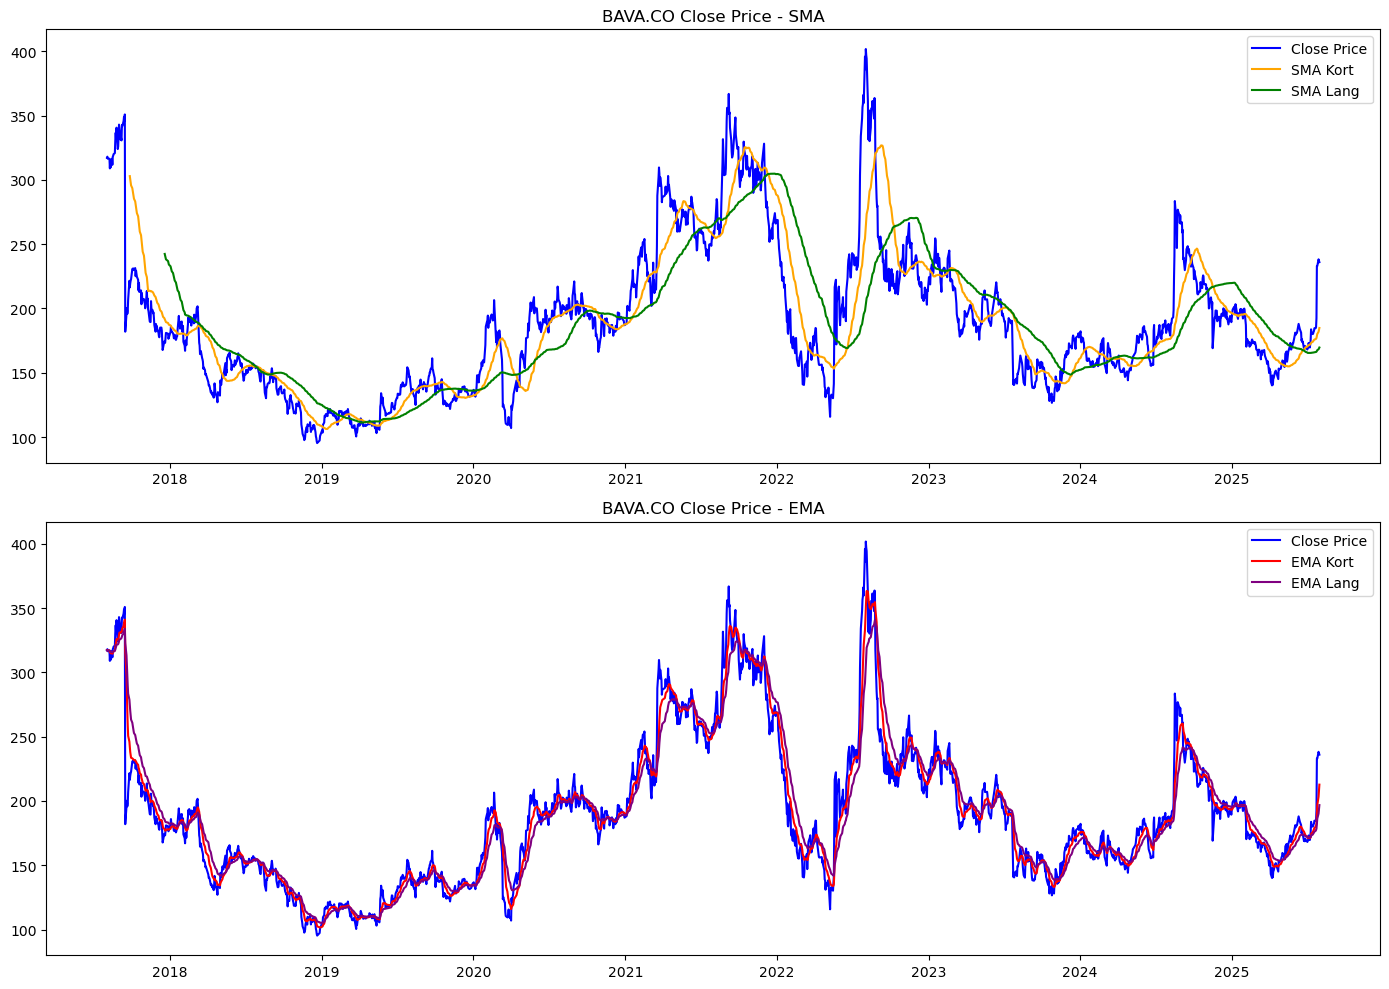

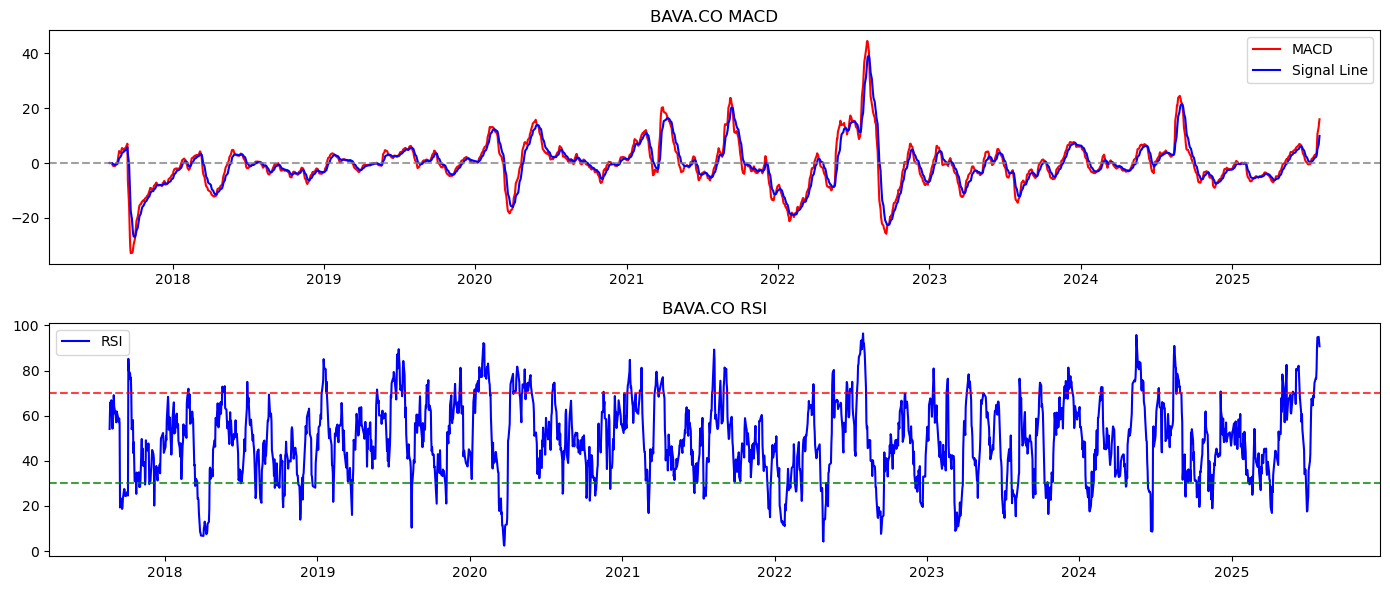

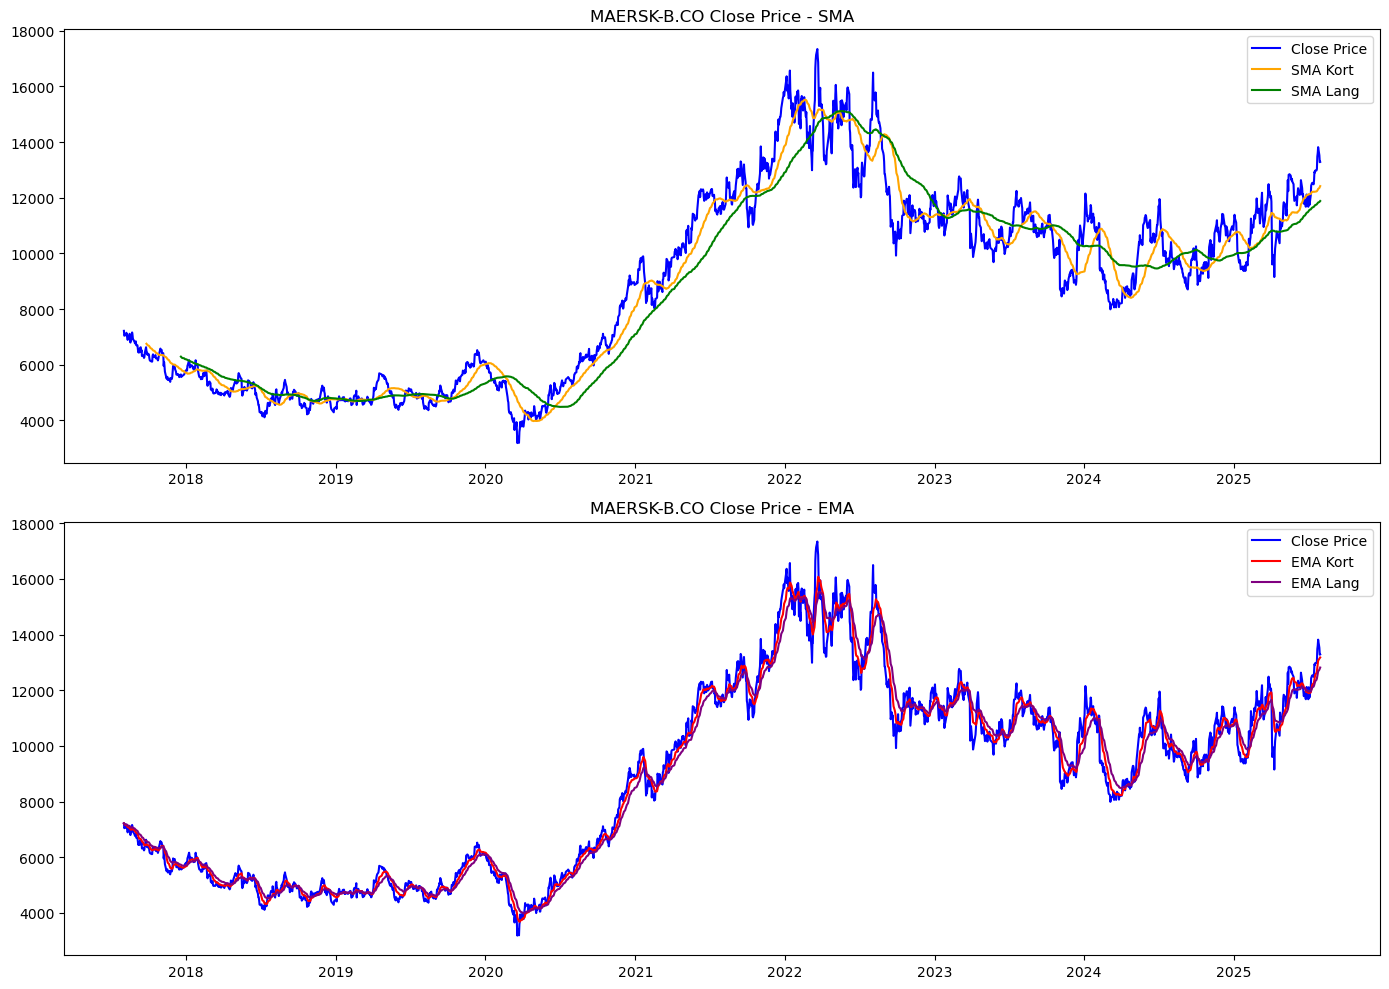

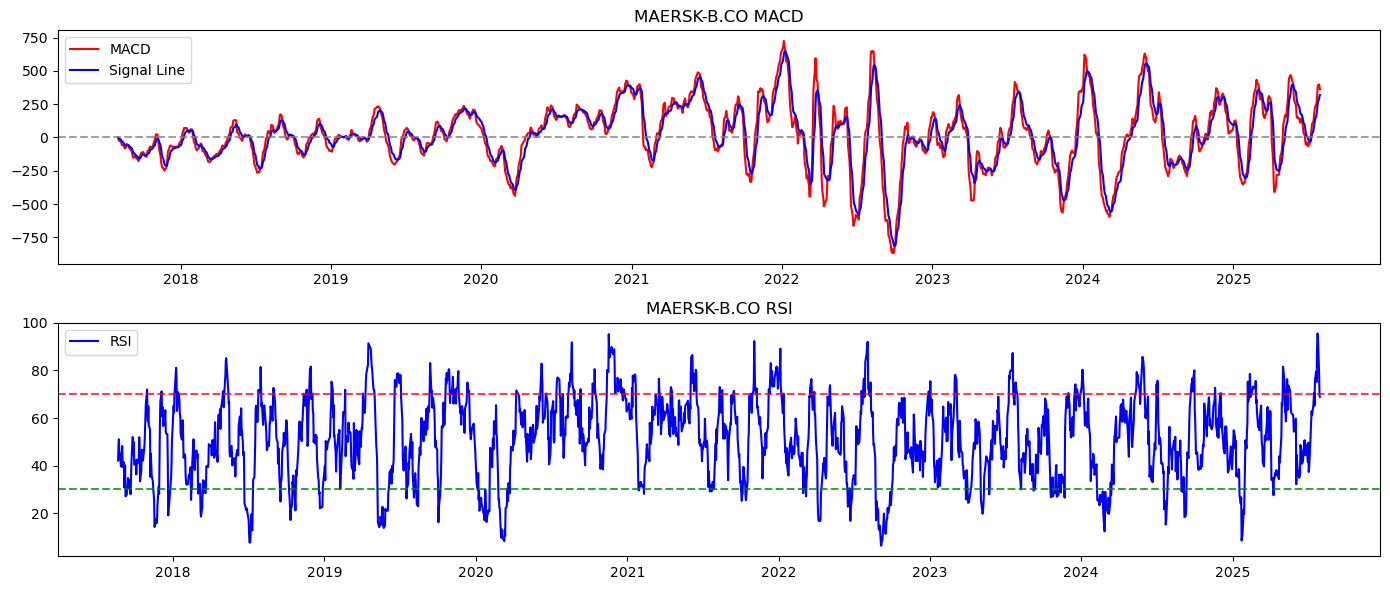

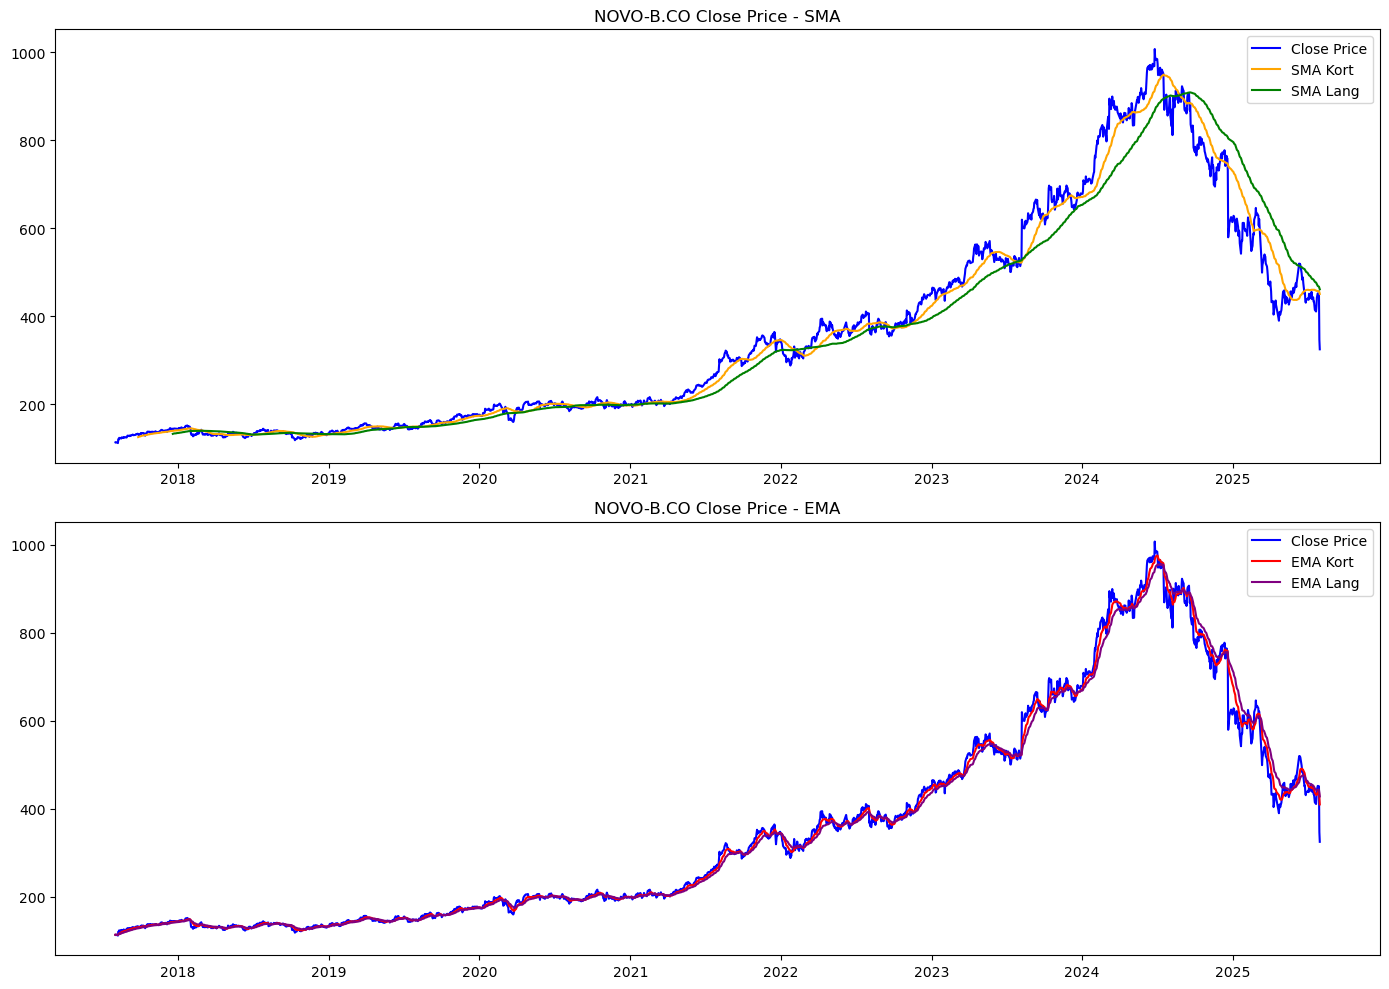

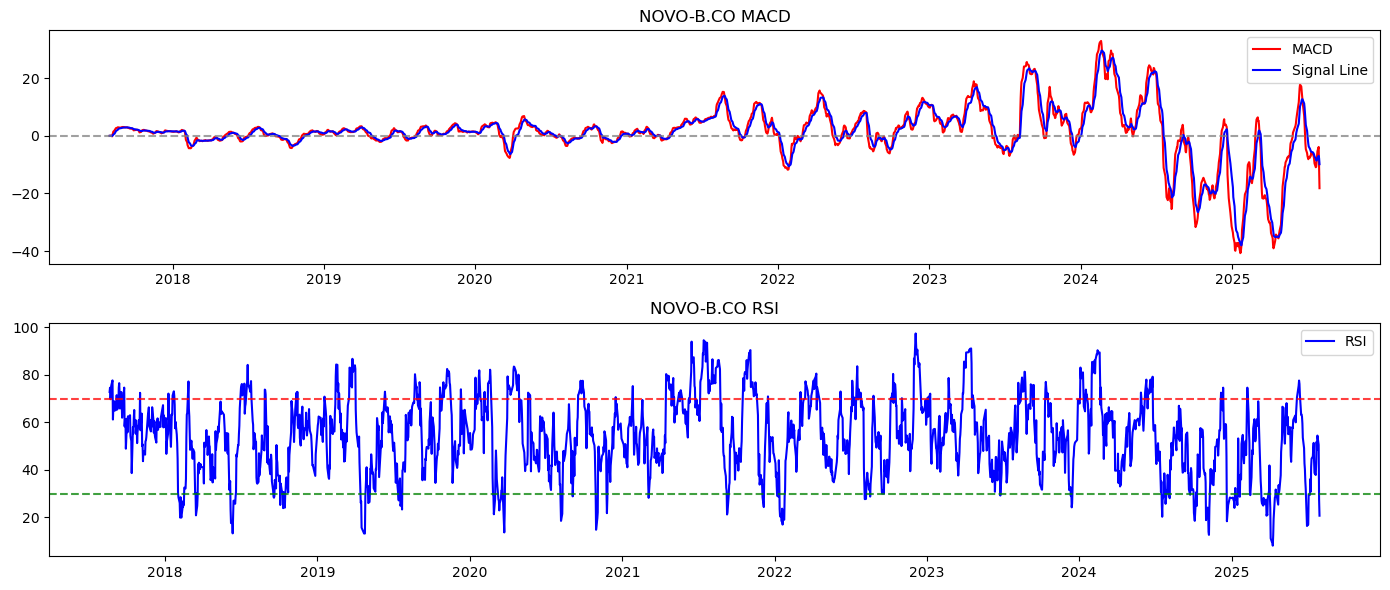

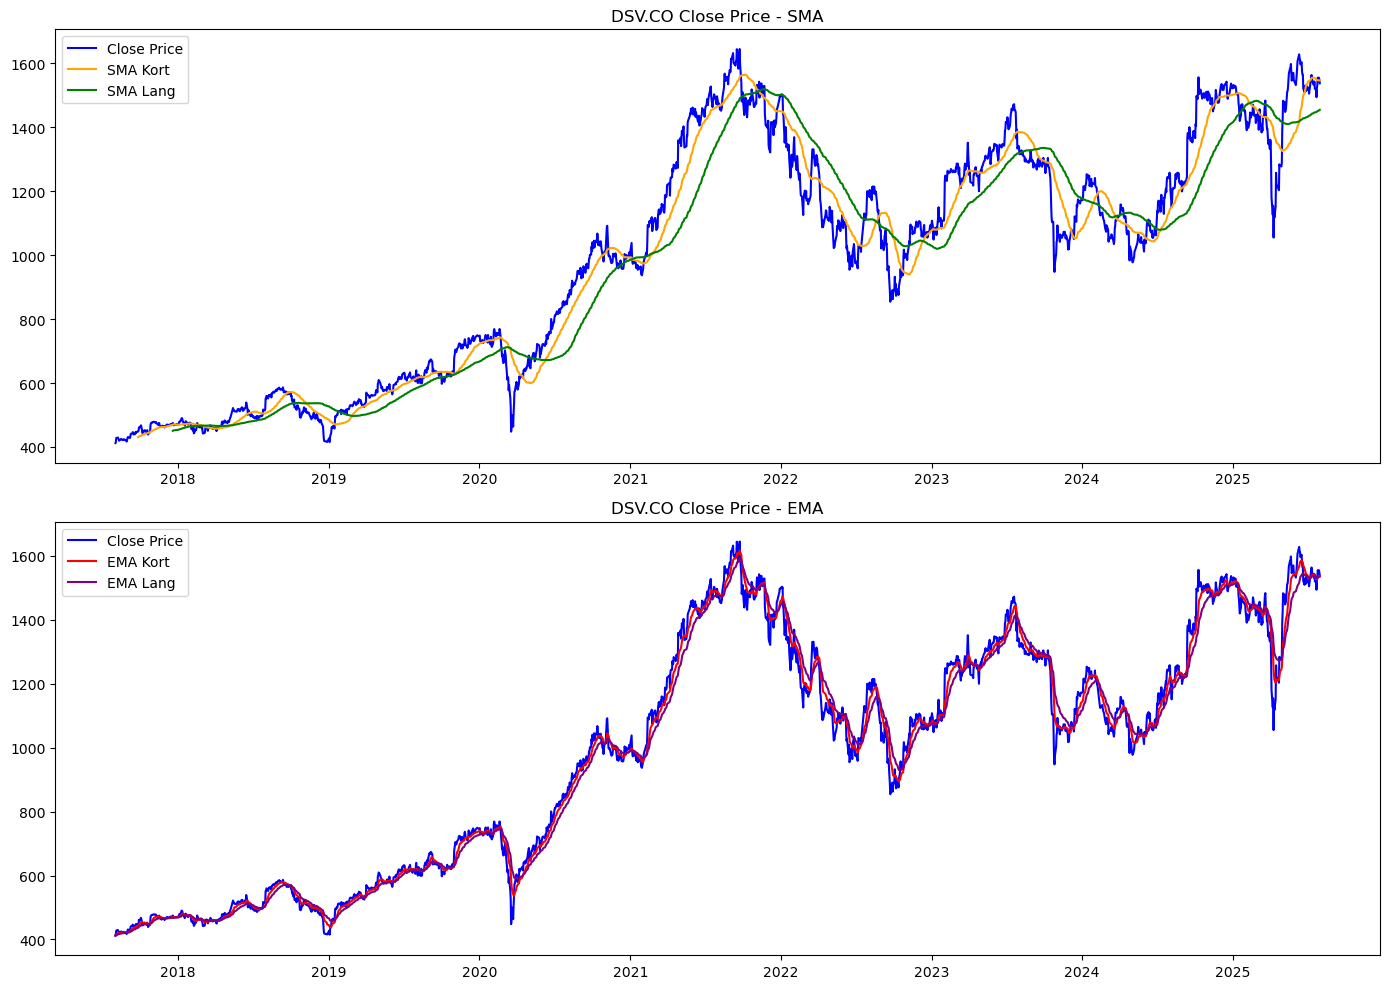

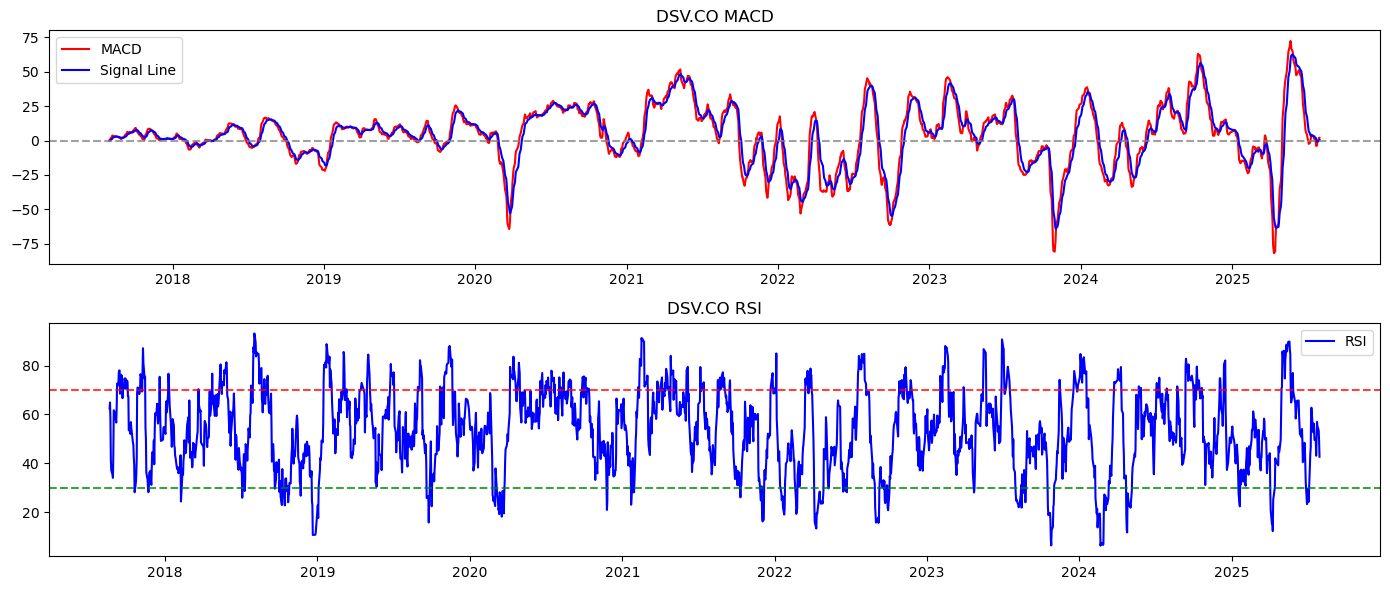

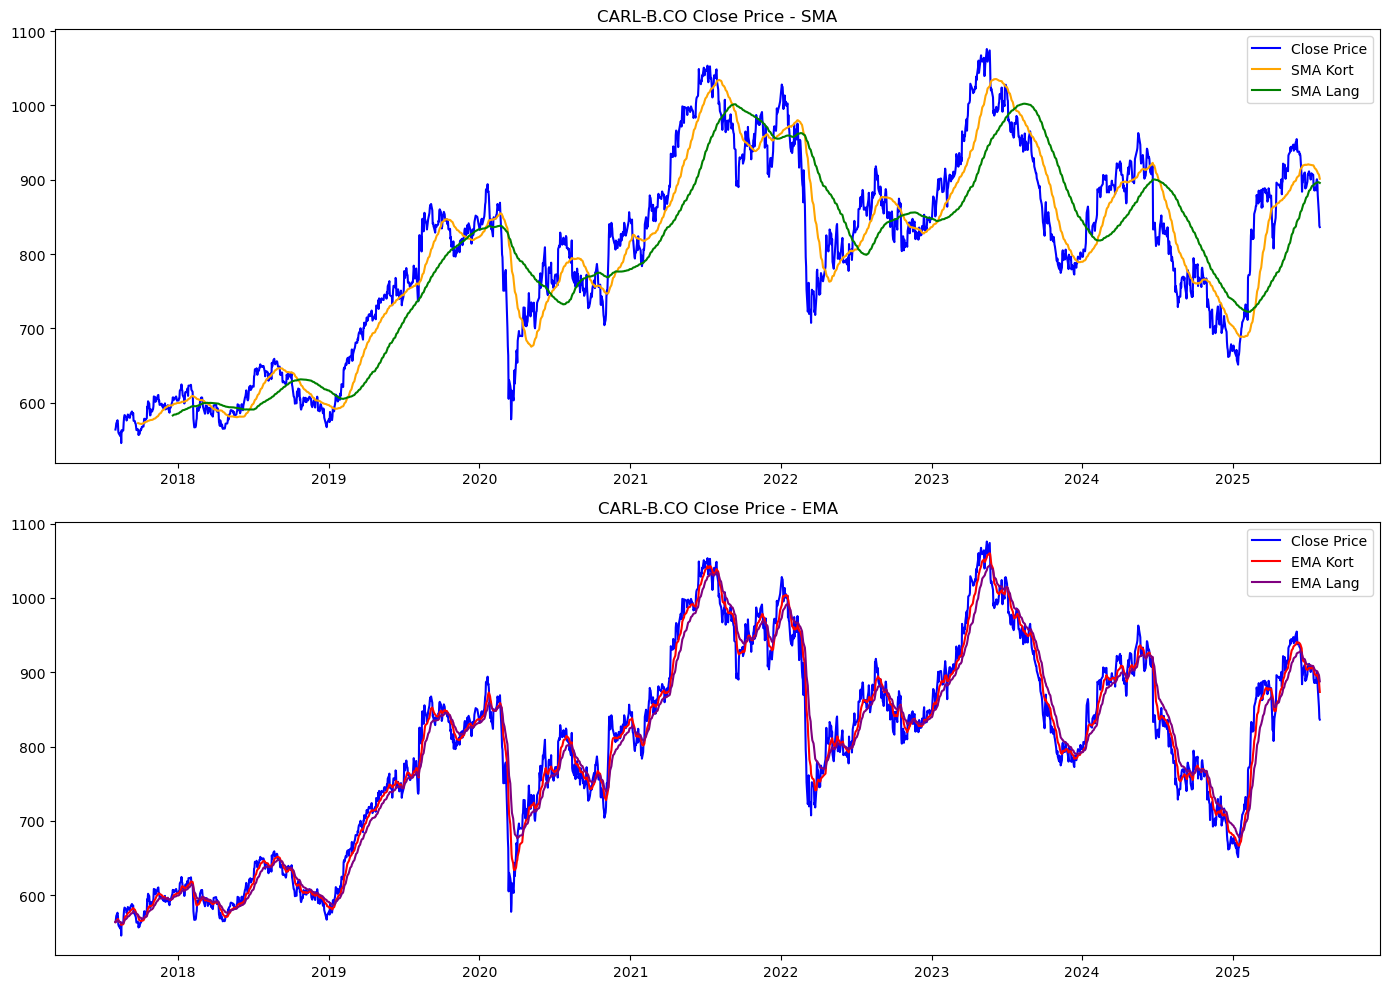

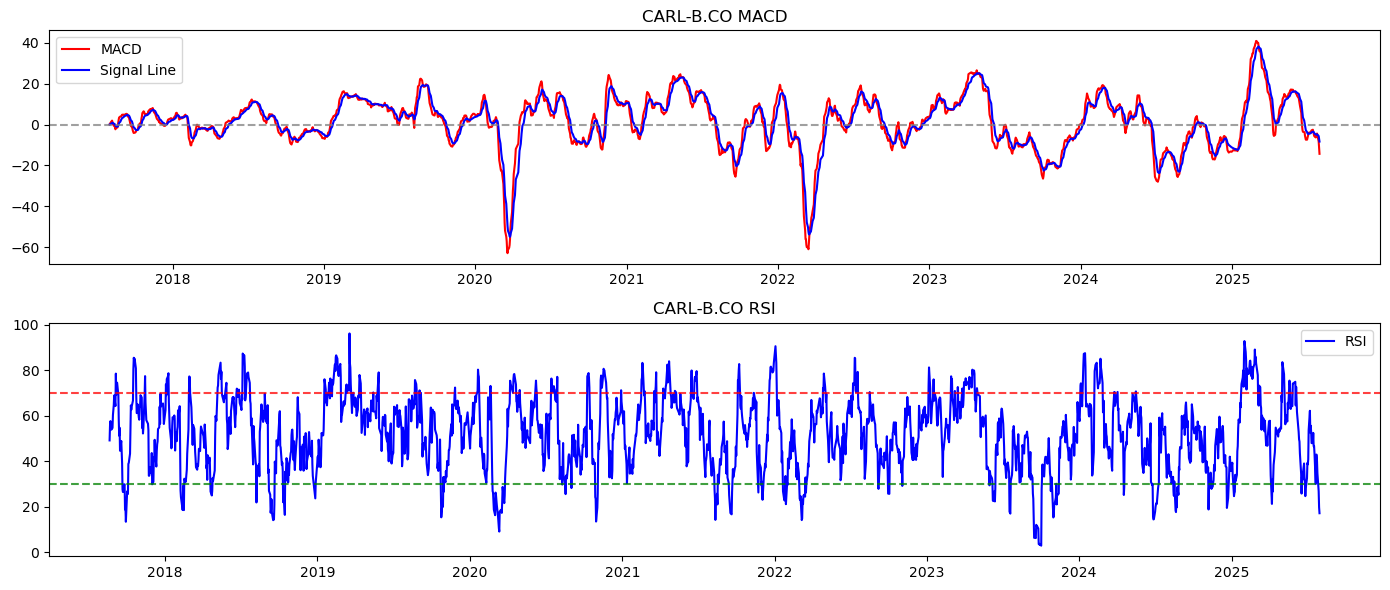

In [22]:
# Valgte symboler (Her med omxc25 symboler)
valgte_symbols = ['BAVA.CO', 'MAERSK-B.CO', 'NOVO-B.CO', 'DSV.CO', 'CARL-B.CO']

# Beregn indikatorer for alle valgte symbler
all_indicators = process_multiple_stocks(individual_c25_data, valgte_symbols)

# Generer plots for hver symbol
for symbol in all_indicators:
    plot_stock_indicators(symbol, all_indicators[symbol])




### YDERLIGERE FEATURE ENGINEERING
***

* Bollinger Bans
* ATR
* Sammensatte features (Krydssignaler)
* Afstand mellem closing-pris og SMA/EMA (i procent)

In [23]:
# Import pandas_ta for til BBands og ATR (kunne også bruges til RSI og MACD ovenfor)
import pandas_ta as ta

#### Bollinger Bands
***

In [24]:
# Bolinger Bands
def bollinger_bands(data: pd.DataFrame, window: int = 20, num_std: int = 2) -> pd.DataFrame:
    """ 
    Args:
    data: DataFrame med aktie data (skal indeholde 'Close' kolonne)
    window: Vindue størrelse (default: 20)
    num_std: Antal standardafvigelser (default: 2.0)

    Returns:
        pd.DataFrame: Input DataFrame med tilføjede Bollinger Bands kolonner
    """

    result = data.copy()

    # udregn BBands
    bb_result = ta.bbands(close=result['Close'], length=window, std=num_std)

    # resultater til dataframe
    result['BB_Upper'] = bb_result['BBU_'+str(window)+'_'+str(float(num_std))]
    result['BB_Middle'] = bb_result['BBM_'+str(window)+'_'+str(float(num_std))]
    result['BB_Lower'] = bb_result['BBL_'+str(window)+'_'+str(float(num_std))]

    # bredde af BBands (volatilitetsindikator)
    result['BB_Width'] = (result['BB_Upper'] - result['BB_Lower']) / result['BB_Middle']

    return result

#### ATR (Average True Range)
***

In [25]:
# ATR 
def atr(data: pd.DataFrame, window: int = 14) -> pd.Series:
    """
    Args:
        data: DataFrame med aktie data (skal indeholde 'High', 'Low', 'Close' kolonner)
        window: Vindue størrelse for ATR (default: 14)
    
    Returns:
        pd.Series: ATR værdier
    """
    result = data.copy()

    # Beregn ATR
    atr = ta.atr(high=result['High'], low=result['Low'], close=result['Close'], length=window)

    result['ATR'] = atr

    return result

In [26]:
# Visualisering af Bollinger Bands og ATR
symbol = 'BAVA.CO'
bava_data = individual_c25_data[symbol]
# Bbands
bava_bb = bollinger_bands(bava_data)
#ATR
bava_atr = atr(bava_bb)

display(bava_atr[['Close', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Width', 'ATR']].tail())


,Close,BB_Upper,BB_Middle,BB_Lower,BB_Width,ATR
Date,,,,,,
2025-07-24 00:00:00+02:00,233.000000,208.183189,180.2625,152.341811,0.309778,7.814416
2025-07-25 00:00:00+02:00,233.000000,219.104318,183.4425,147.780683,0.388806,8.034815
2025-07-28 00:00:00+02:00,238.199997,229.112580,186.9050,144.697421,0.451647,8.132327
2025-07-29 00:00:00+02:00,237.000000,236.881537,190.3500,143.818463,0.488905,7.880019
2025-07-30 00:00:00+02:00,236.000000,243.163614,193.6925,144.221386,0.510821,7.588589


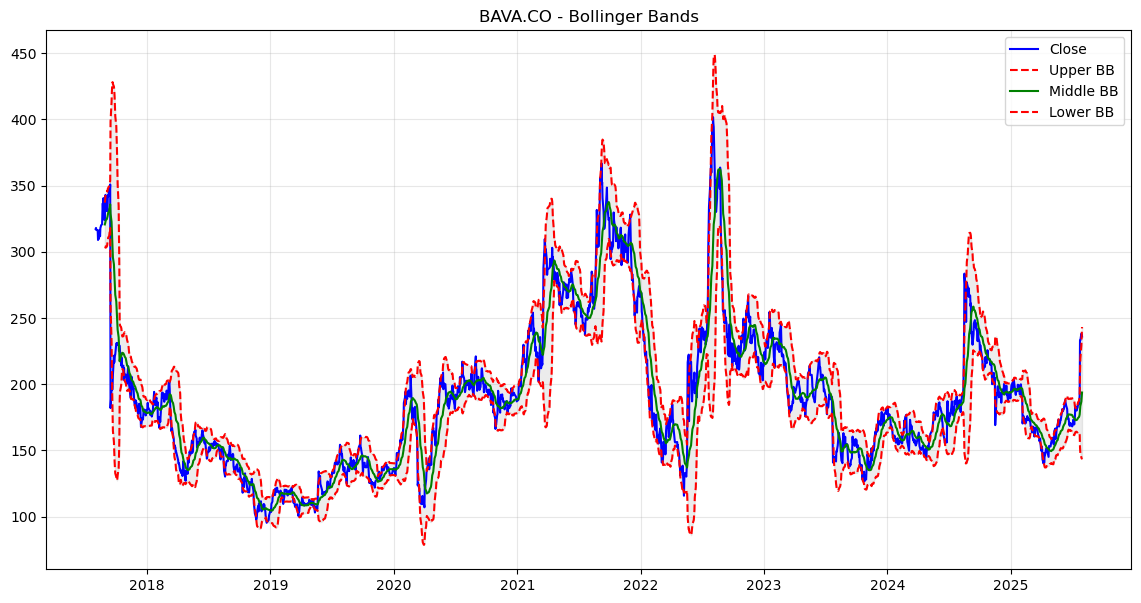

In [27]:
# plot bbands
plt.figure(figsize=(14, 7)) 
plt.plot(bava_atr.index, bava_atr['Close'], label='Close', color='blue') 
plt.plot(bava_atr.index, bava_atr['BB_Upper'], label='Upper BB', color='red', linestyle='--') 
plt.plot(bava_atr.index, bava_atr['BB_Middle'], label='Middle BB', color='green') 
plt.plot(bava_atr.index, bava_atr['BB_Lower'], label='Lower BB', color='red', linestyle='--') 
plt.fill_between(bava_atr.index, bava_atr['BB_Upper'], bava_atr['BB_Lower'], color='gray', alpha=0.15) 
plt.title(f'{symbol} - Bollinger Bands') 
plt.legend() 
plt.grid(True, alpha=0.3) 
plt.show()

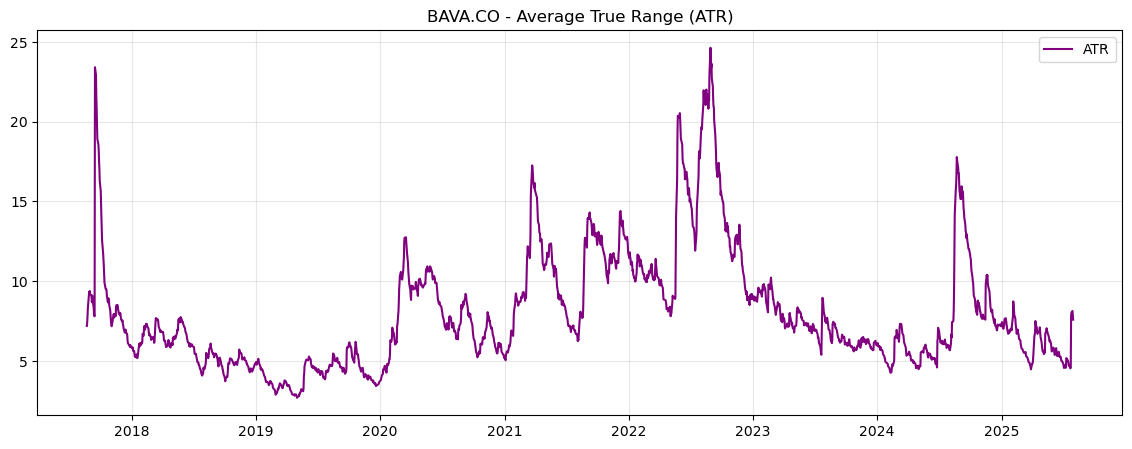

In [28]:
#plot atr
plt.figure(figsize=(14, 5))
plt.plot(bava_atr.index, bava_atr['ATR'], label='ATR', color='purple')
plt.title(f'{symbol} - Average True Range (ATR)')
plt.legend()
plt.grid(True, alpha=0.3)

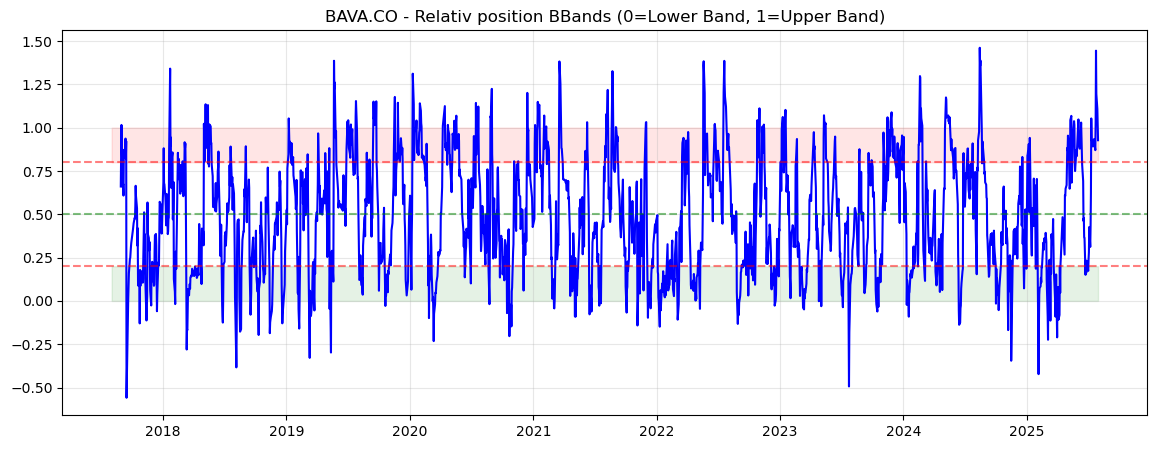

In [29]:
bava_atr['BB_Position'] = (bava_atr['Close'] - bava_atr['BB_Lower']) / (bava_atr['BB_Upper'] - bava_atr['BB_Lower'])

plt.figure(figsize=(14, 5)) 
plt.plot(bava_atr.index, bava_atr['BB_Position'], color='blue') 
plt.axhline(0.5, color='green', linestyle='--', alpha=0.5) 
plt.axhline(0.8, color='red', linestyle='--', alpha=0.5) 
plt.axhline(0.2, color='red', linestyle='--', alpha=0.5) 
plt.fill_between(bava_atr.index, 0.8, 1, color='red', alpha=0.1) 
plt.fill_between(bava_atr.index, 0, 0.2, color='green', alpha=0.1) 
plt.title(f'{symbol} - Relativ position BBands (0=Lower Band, 1=Upper Band)') 
plt.grid(True, alpha=0.3) 
plt.show()

#### KRYDSSIGNLAER
***

In [30]:
# implementering af SMA krydssignaler
def kryds_signaler(data: pd.DataFrame, sma_kort: str = 'SMA_Kort', sma_lang: str = 'SMA_Lang') -> pd.DataFrame:
    """
    Args:
        data: DataFrame med aktie data (skal indeholde SMA kolonner)
        sma_kort: Kolonnenavn for kort SMA
        sma_lang: Kolonnenavn for lang SMA
    
    Returns:
        pd.DataFrame: DataFrame med krydssignaler
    """
    result = data.copy()
    
    # signaler
    result['Krydssignal'] = 0
    result.loc[result[sma_kort] > result[sma_lang], 'Krydssignal'] = 1  # Kort over lang
    result.loc[result[sma_kort] < result[sma_lang], 'Krydssignal'] = -1  # Kort under lang
    
    return result

In [39]:
symbol = 'BAVA.CO'
bava_data = individual_c25_data[symbol]
bava_signals = kryds_signaler(bava_data)

display(bava_signals[['Close', 'SMA_Kort', 'SMA_Lang', 'Krydssignal']])

,Close,SMA_Kort,SMA_Lang,Krydssignal
Date,,,,
2017-08-02 00:00:00+02:00,317.217468,NaN,NaN,0
2017-08-03 00:00:00+02:00,318.008545,NaN,NaN,0
2017-08-04 00:00:00+02:00,316.426392,NaN,NaN,0
2017-08-07 00:00:00+02:00,316.426392,NaN,NaN,0
2017-08-08 00:00:00+02:00,316.426392,NaN,NaN,0
...,...,...,...,...
2025-07-24 00:00:00+02:00,233.000000,178.66000,166.9695,1
2025-07-25 00:00:00+02:00,233.000000,180.21000,167.5775,1
2025-07-28 00:00:00+02:00,238.199997,181.84125,168.2480,1


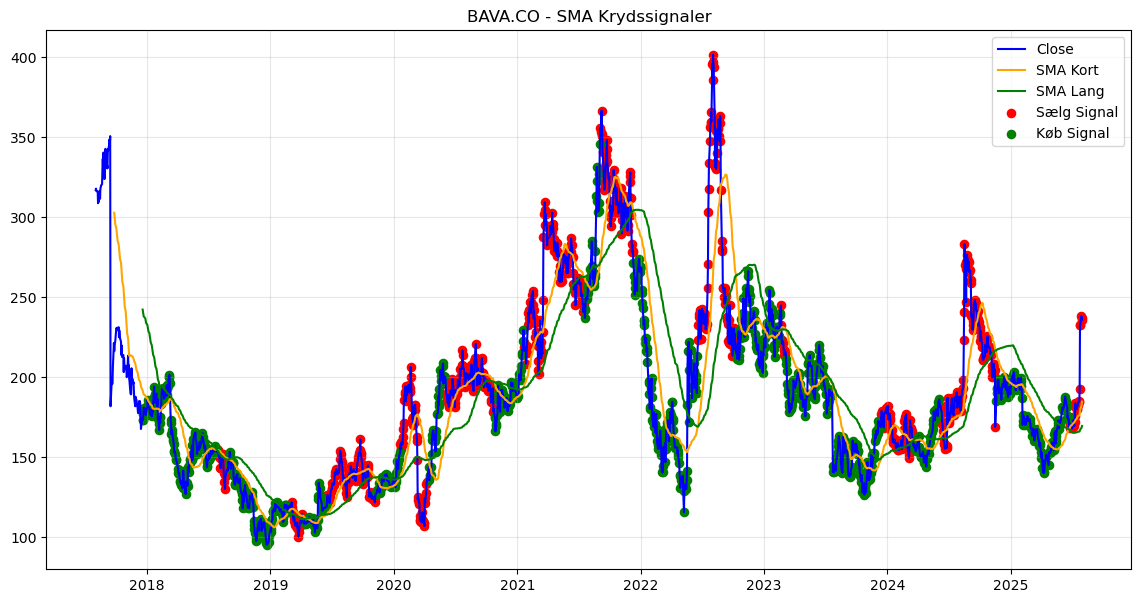

In [54]:
# plot
symbol = 'BAVA.CO'
plt.figure(figsize=(14, 7))
plt.plot(bava_signals.index, bava_signals['Close'], label='Close', color='blue')
plt.plot(bava_signals.index, bava_signals['SMA_Kort'], label='SMA Kort', color='orange')
plt.plot(bava_signals.index, bava_signals['SMA_Lang'], label='SMA Lang', color='green')

plt.scatter(bava_signals.index[bava_signals['Krydssignal'] == 1], 
            bava_signals['Close'][bava_signals['Krydssignal'] == 1], 
            marker='o', color='red', label='Sælg Signal', s=35)
plt.scatter(bava_signals.index[bava_signals['Krydssignal'] == -1], 
            bava_signals['Close'][bava_signals['Krydssignal'] == -1], 
            marker='o', color='green', label='Køb Signal', s=35)
plt.title(f'{symbol} - SMA Krydssignaler')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()  

In [41]:
symbol = 'MAERSK-B.CO'
maersk_data = individual_c25_data[symbol]
maersk_data['SMA_Kort'] = maersk_data['Close'].rolling(window=40).mean()
maersk_data['SMA_Lang'] = maersk_data['Close'].rolling(window=100).mean()
maersk_signals = kryds_signaler(maersk_data)

display(maersk_signals[['Close', 'SMA_Kort', 'SMA_Lang', 'Krydssignal']])

,Close,SMA_Kort,SMA_Lang,Krydssignal
Date,,,,
2017-08-02 00:00:00+02:00,7216.649902,NaN,NaN,0
2017-08-03 00:00:00+02:00,7041.409668,NaN,NaN,0
2017-08-04 00:00:00+02:00,7062.651855,NaN,NaN,0
2017-08-07 00:00:00+02:00,7062.651855,NaN,NaN,0
2017-08-08 00:00:00+02:00,7147.616211,NaN,NaN,0
...,...,...,...,...
2025-07-24 00:00:00+02:00,13600.000000,12281.125,11805.142432,1
2025-07-25 00:00:00+02:00,13815.000000,12314.375,11826.023691,1
2025-07-28 00:00:00+02:00,13525.000000,12350.375,11845.780371,1


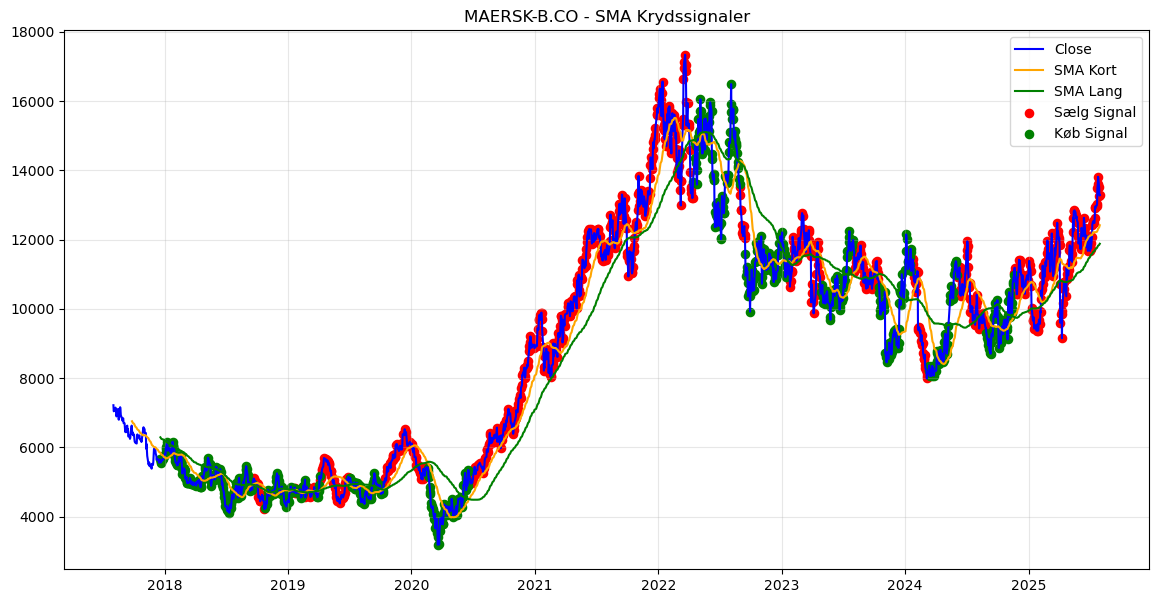

In [53]:
symbol = 'MAERSK-B.CO'
plt.figure(figsize=(14, 7))
plt.plot(maersk_signals.index, maersk_signals['Close'], label='Close', color='blue')
plt.plot(maersk_signals.index, maersk_signals['SMA_Kort'], label='SMA Kort', color='orange')
plt.plot(maersk_signals.index, maersk_signals['SMA_Lang'], label='SMA Lang', color='green')

plt.scatter(maersk_signals.index[maersk_signals['Krydssignal'] == 1], 
            maersk_signals['Close'][maersk_signals['Krydssignal'] == 1], 
            marker='o', color='red', label='Sælg Signal', s=35)
plt.scatter(maersk_signals.index[maersk_signals['Krydssignal'] == -1], 
            maersk_signals['Close'][maersk_signals['Krydssignal'] == -1], 
            marker='o', color='green', label='Køb Signal', s=35)
plt.title(f'{symbol} - SMA Krydssignaler')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()  

#### Afstand mellem closingpris og SMA
***

In [58]:
# procentvis afstand mellem closing pris og SMA
def sma_afstand(data: pd.DataFrame, sma_kort: str = 'SMA_Kort', sma_lang: str = 'SMA_Lang') -> pd.DataFrame:
    """
    Args:
        data: DataFrame med aktie data (skal indeholde 'Close' kolonne og SMA kolonner)
        sma_kort: Kolonnenavn for kort SMA
        sma_lang: Kolonnenavn for lang SMA
    
    Returns:
        pd.DataFrame: DataFrame med procentvis afstand til SMA
    """
    result = data.copy()
    
    # Beregn procentvis afstand
    result['Afstand_Kort'] = (result['Close'] - result[sma_kort]) / result[sma_kort] * 100
    result['Afstand_Lang'] = (result['Close'] - result[sma_lang]) / result[sma_lang] * 100
    
    return result



In [59]:
# på BAVA data
bava_afstand = sma_afstand(bava_signals)
display(bava_afstand[['Close', 'SMA_Kort', 'SMA_Lang', 'Afstand_Kort', 'Afstand_Lang']])

,Close,SMA_Kort,SMA_Lang,Afstand_Kort,Afstand_Lang
Date,,,,,
2017-08-02 00:00:00+02:00,317.217468,NaN,NaN,NaN,NaN
2017-08-03 00:00:00+02:00,318.008545,NaN,NaN,NaN,NaN
2017-08-04 00:00:00+02:00,316.426392,NaN,NaN,NaN,NaN
2017-08-07 00:00:00+02:00,316.426392,NaN,NaN,NaN,NaN
2017-08-08 00:00:00+02:00,316.426392,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-07-24 00:00:00+02:00,233.000000,178.66000,166.9695,30.415314,39.546444
2025-07-25 00:00:00+02:00,233.000000,180.21000,167.5775,29.293602,39.040146
2025-07-28 00:00:00+02:00,238.199997,181.84125,168.2480,30.993379,41.576718
